# Setup

In [ ]:
!pip install shap
!pip install autocorrect
!pip install line_profiler
%load_ext line_profiler

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
import sys
try:
  from google.colab import drive
  drive.mount('/gdrive')
  sys.path.append("/gdrive/MyDrive/Colab Notebooks/base")
  drivePath = '/gdrive/MyDrive/Colab Notebooks/data/'
except:
    sys.path.append("./base")
    drivePath = './data/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [5]:
# Main
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import itertools
import copy

# Visualization
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Data preprocessing
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Text preprocessing
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from autocorrect import Speller
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Feature_selection
from sklearn.feature_selection import VarianceThreshold

# Modeling
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost.core import Pool

# Performace indicators and Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

# Interpretation
import shap

# Utilities
from sklearn_pandas import DataFrameMapper, gen_features
import time

# Custom functions
from networkgraph import NetworkGraph
from feature_importance import FeatureImportance 

# Settings
from sklearn import set_config
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
set_config(display='diagram')
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
class PandasSimpleImputer(SimpleImputer):
    """A wrapper around `SimpleImputer` to return data frames with columns.
    """
    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)

one_dim = FunctionTransformer(np.reshape, kw_args={'newshape':-1})

def model_performance(X0, X1, Y0, Y1, model):
    Y0_predict = model.predict(X0)
    Y1_predict = model.predict(X1)

    Y0_hat = model.predict_proba(X0)[:, 1]
    Y1_hat = model.predict_proba(X1)[:, 1]

    print('\nROC AUC Train', roc_auc_score(Y0, Y0_hat).round(3))
    print('ROC AUC Test', roc_auc_score(Y1, Y1_hat).round(3))

In [7]:
# class Tokenizer(object):
#     def __init__(self):
#         nltk.download('punkt', quiet=True, raise_on_error=True)
#         self.stemmer = nltk.stem.PorterStemmer()
#         self.wnl = WordNetLemmatizer()

#     def _stem(self, token):
#         return self.stemmer.stem(token)
        
#     def __call__(self, line):
#         tokens = regexp_tokenize(line, pattern=r"(?!\w+).|\d+", gaps=True)
#         tokens = (self._stem(token) for token in tokens  if not token in sw_nltk)
#         return list(tokens)

def correlation_groups(data, threshold=0.98):
    #convert matrix to list of edges and rename the columns
    edges = data.corr(method='pearson')
    edges = edges.mask(np.tril(np.ones(edges.shape)).astype(np.bool))
    edges = edges[abs(edges) >= 0.5].abs().stack().reset_index()
    edges.columns = ['value_1','value_2','correlation']
    edges = edges[edges['correlation'] >= threshold]

    #show the first 5 rows of the edge list dataframe.
    clusters = []
    for val in edges.values:
        one_in = False
        appended = False
        for cluster in clusters:
            one_in = val[0] in cluster
            appended = one_in and (val[1] not in cluster)
            if appended:
                cluster.append(val[1])
                break
        if (not appended) and (not one_in):
            clusters.append([val[0], val[1]])

    # display(edges.sort_values('correlation', ascending=False).head(30))
    return clusters

In [8]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:
        raw_col_name = list(transformer_in_columns[2])
        if isinstance(transformer_in_columns[1], Pipeline): 
            # if pipeline, get the last transformer
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
          if isinstance(transformer, OneHotEncoder):
            names = list(transformer.get_feature_names(raw_col_name))
          elif isinstance(transformer, SimpleImputer) and transformer.add_indicator:
            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [raw_col_name[idx] + '_missing_flag' for idx in missing_indicator_indices]
            names = raw_col_name + missing_indicators
          else:
            names = list(transformer.get_feature_names())
        except AttributeError as error:
          names = raw_col_name
        col_name.extend(names)
    return col_name

In [9]:
original_dataset = pd.read_csv(drivePath+'SS_dataset.csv', index_col=0)

In [10]:
data = original_dataset
text_data = 'Description'
data[text_data] = data[text_data].fillna('')

for col in data.drop(text_data, axis=1).dtypes[data.dtypes == 'object'].index:
    data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470 entries, company1 to company472
Columns: 111 entries, Dependent-Company Status to Description
dtypes: category(66), float64(41), int64(3), object(1)
memory usage: 206.9+ KB


# Exploratory analysis

In [11]:
original_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470 entries, company1 to company472
Columns: 111 entries, Dependent-Company Status to Description
dtypes: category(66), float64(41), int64(3), object(1)
memory usage: 206.9+ KB


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 470 entries, company1 to company472
Columns: 111 entries, Dependent-Company Status to Description
dtypes: category(66), float64(41), int64(3), object(1)
memory usage: 206.9+ KB


In [13]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:",data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 7536
Single valued columns: Index([], dtype='object')


In [14]:
plt.rc("font", size=14)
sns.set(style="dark")
sns.set(style="whitegrid", palette='dark', color_codes=True)

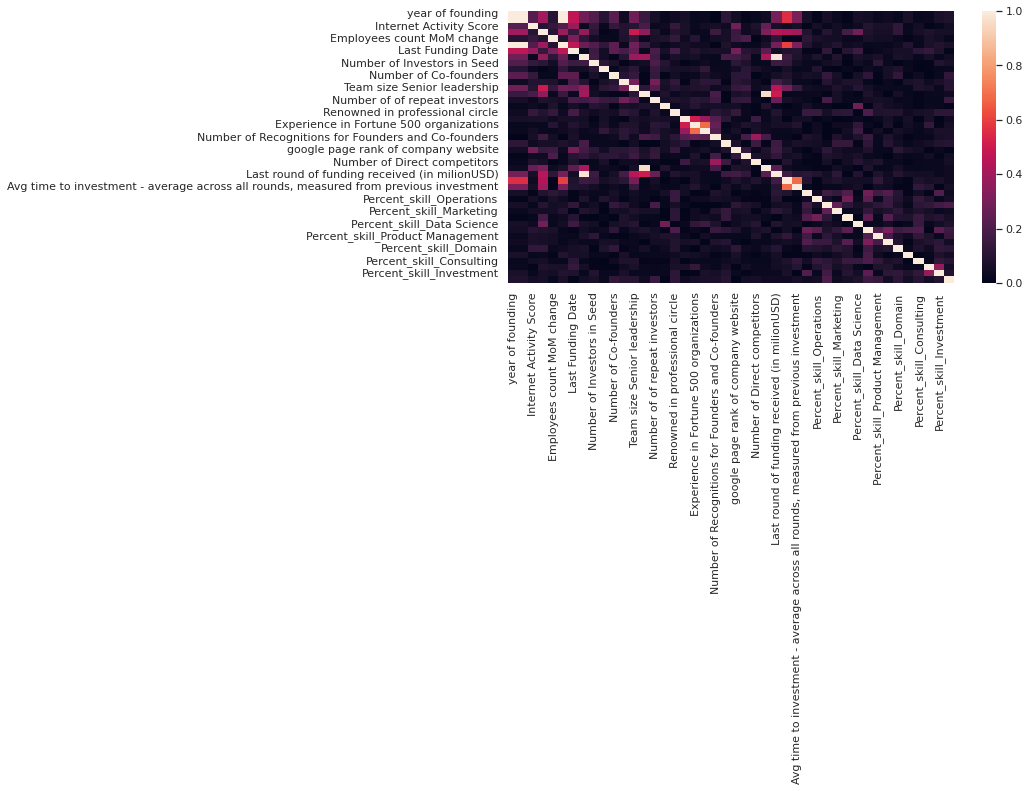

In [15]:
plt.figure(figsize=(10,5))
corrMatrix = data.corr()
sns.heatmap(corrMatrix.round(2).abs())
plt.show()

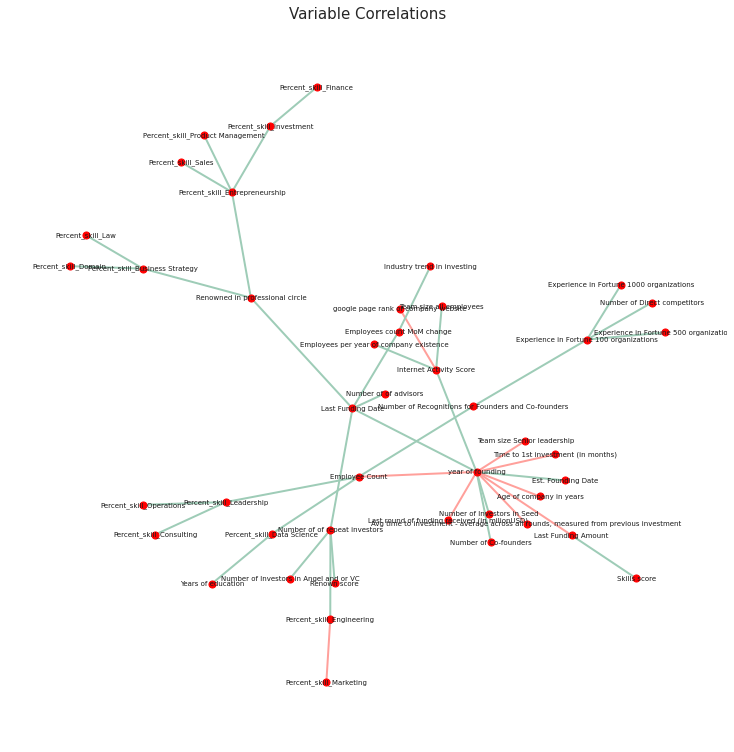

In [16]:
correlation_matrix = data.corr()

Gx = NetworkGraph(correlation_matrix, 0.15)
Gx.draw_network_graph(layout_type='minimum_spanning_tree', title='Variable Correlations', 
                      figsize=(10,10), with_labels=True, title_fontsize=15, 
                      node_color="red", mst_node_size=50, mst_edge_width=2, 
                      font_size=7)
plt.show()

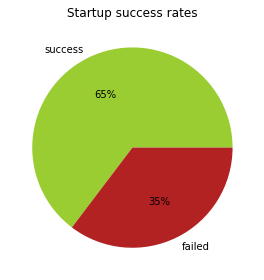

In [17]:
sns.reset_orig()
fig, ax = plt.subplots()
ratios = (data['Dependent-Company Status'].value_counts()/data['Dependent-Company Status'].count()*100).round(2)
labels = data['Dependent-Company Status'].unique()
ax.pie(ratios, labels=labels, autopct='%1.0f%%', pctdistance=0.6, labeldistance=1.1, radius=1, colors=['yellowgreen', 'firebrick'])
ax.set_title('Startup success rates')
plt.tight_layout()

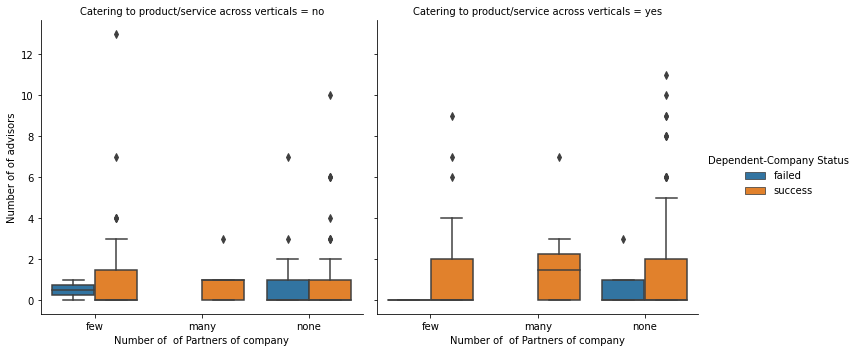

In [18]:
dplot = sns.catplot(x='Number of  of Partners of company', y='Number of of advisors',
                     data=data, hue='Dependent-Company Status', 
                      col='Catering to product/service across verticals',
                      kind='box', legend_out=True)
plt.show()

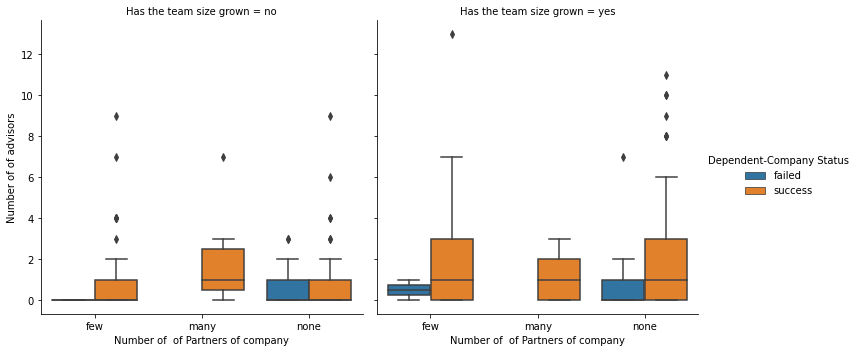

In [19]:
dplot = sns.catplot(x='Number of  of Partners of company', y='Number of of advisors',
                     data=data, hue='Dependent-Company Status', 
                      col='Has the team size grown',
                      kind='box', legend_out=True)
plt.show()

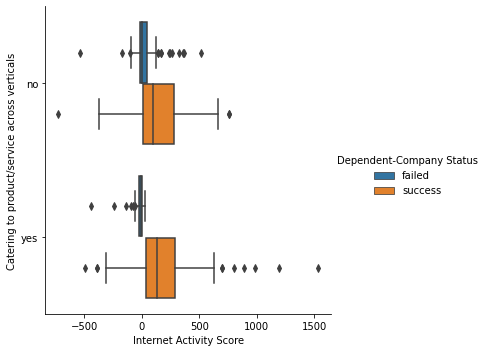

In [20]:
dplot = sns.catplot(x='Internet Activity Score', y='Catering to product/service across verticals',
                     data=data, hue='Dependent-Company Status',
                      kind='box', legend_out=True)
plt.show()

In [21]:
data.isna().sum()[data.isna().sum() / data.shape[0] >= 0.3].index

Index(['Employee Count', 'Employees count MoM change', 'Last Funding Amount',
       'Employee benefits and salary structures', 'Client Reputation',
       'google page rank of company website',
       'Last round of funding received (in milionUSD)',
       'Gartner hype cycle stage',
       'Time to maturity of technology (in years)'],
      dtype='object')

# Running Logistic Regression

In [22]:
sw_nltk = stopwords.words('english')

class Tokenizer(object):
    def __init__(self):
        self.stop_words = sw_nltk
        self.spell = Speller(lang='en',fast=True)
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.PorterStemmer()
    def __call__(self, doc):
        return [self.lemmatizer.lemmatize(t) for t in regexp_tokenize(self.spell(doc), pattern=r"(?!\w+).|\d+", gaps=True) if not t in self.stop_words]

numeric_transformer = Pipeline(steps=[
    ('StandardScaler', StandardScaler()),
    ('NumericImputer', SimpleImputer(strategy='median', add_indicator=True))
    ])

categorical_transformer = Pipeline(steps=[
    ('BinaryImputer', PandasSimpleImputer(strategy='constant', fill_value='Missing')),                                
    ('CategoricalEncoder', OneHotEncoder(drop='if_binary', handle_unknown="ignore"))
    ])

text_transformer = Pipeline(steps=[
    ('TextImputer', SimpleImputer(strategy='constant', fill_value='Missing')),   
    ('DimensionalConverter', one_dim),
    ('TextDigitizer', CountVectorizer(tokenizer=Tokenizer(),
                                      lowercase='True', ngram_range=(1,1), 
                                      max_features=5))
    ])

# entire pipeline
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, selector(dtype_include=["float64", 'int64'])),
    ('categorical', categorical_transformer, selector(dtype_include="category")),
    ('text', text_transformer, selector(dtype_include="object"))
], n_jobs=-1)

feature_selector = SelectKBest(score_func=mutual_info_classif, k=91)

# Setting up variables
target = 'Dependent-Company Status'
temp_data = data.sample(frac=1, random_state=42)

y = temp_data[target]
X = temp_data.drop(target, axis=1)

# Splittind data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

LR_model = LogisticRegression(penalty='l2', C=0.11888888888888888, solver='liblinear', random_state=42, n_jobs=-1)

LR = Pipeline(steps=[('preprocessor', preprocessor),
                     ('selector', feature_selector),
                     ('classifier', LR_model)])

# LR_search_params = {
#     'preprocessor__numeric__NumericImputer__strategy': ['mean', 'constant'],
#     'preprocessor__categorical__BinaryImputer__strategy': ['most_frequent', 'constant'],
#     'preprocessor__text__TextImputer__strategy': ['most_frequent', 'constant'],
#     'preprocessor__text__TextDigitizer__max_features': np.arange(10, 30, 10),
#     'selector__n_features_to_select': np.arange(0.05, 0.3, 0.05),
#     'classifier__C': np.arange(1, 7, 1)
#     }

LR_search_params = {
    'selector__k': np.arange(90, 100, 1),
    'classifier__C': np.linspace(0.01, 0.5, 10)
    }
lr_gs = GridSearchCV(estimator=LR, param_grid=LR_search_params, scoring="roc_auc", cv=cv, verbose=1)
display(lr_gs)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=-1,
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('StandardScaler',
                                                                                          StandardScaler()),
                                                                                         ('NumericImputer',
                                                                                          SimpleImputer(add_indicator=True,
                                                                                                        strategy='median'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector...
                                                    score_func=<function mutual_info_classif at 0x7fef0240eb90>)),
                                       ('classifier',
                                        LogisticRegression(C=0.11888888888888888,
                                                           n_jobs=-1,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': array([0.01      , 0.06444444, 0.11888889, 0.17333333, 0.22777778,
       0.28222222, 0.33666667, 0.39111111, 0.44555556, 0.5       ]),
                         'selector__k': array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
             scoring='roc_auc', verbose=1)

In [23]:
%prun LR.fit(X_train, y_train)

In [24]:
# print('Initial results:')
# np.random.seed(42)
# LR.fit(X_train, y_train)
# model_performance(X_train, X_test, y_train, y_test, LR)
# cv5f = cross_val_score(estimator=LR, X=X, y=y, cv=cv, scoring="roc_auc")
# print("5-fold ROC AUC scores:",cv5f.round(2))
# print("5-fold ROC AUC score mean:", np.mean(cv5f).round(2))
# print("5-fold ROC AUC score std:", np.std(cv5f).round(2))

In [25]:
# %%time
# np.random.seed(42)
# lr_gs.fit(X_train, y_train)
# print('Best Params:', lr_gs.best_params_)
# print('ROC AUC score:', round((lr_gs.best_score_), 4))
# model_performance(X_train, X_test, y_train, y_test, lr_gs.best_estimator_)
# cv5f = cross_val_score(estimator=lr_gs.best_estimator_, X=X, y=y, cv=cv, scoring="roc_auc")
# print("5-fold ROC AUC scores:",cv5f.round(2))
# print("Mean 5-fold ROC AUC score:",np.mean(cv5f).round(2))
# print("Std 5-fold ROC AUC score:", np.std(cv5f).round(2))

In [26]:
np.random.seed(42)
LR.fit(X_train, y_train)
model_performance(X_train, X_test, y_train, y_test, LR)
cv5f = cross_val_score(estimator=LR, X=X, y=y, cv=cv, scoring="roc_auc")
print("5-fold ROC AUC scores:",cv5f.round(2))
print("5-fold ROC AUC score mean:", np.mean(cv5f).round(2))
print("5-fold ROC AUC score std:", np.std(cv5f).round(2))


ROC AUC Train 0.985
ROC AUC Test 0.934
5-fold ROC AUC scores: [0.95 0.94 0.96 0.96 0.97]
5-fold ROC AUC score mean: 0.95
5-fold ROC AUC score std: 0.01


# Logit Interpretation

In [27]:
# Model definition
model = LR
base_model = model.named_steps['classifier']
features_names = get_column_names_from_ColumnTransformer(model.named_steps['preprocessor'])
selected_feature_indices = np.array([int(feature[1:]) for feature in model.named_steps["selector"].get_feature_names_out()])
selected_features = np.array(features_names)[selected_feature_indices]

# Train exp
X_train_raw = model.named_steps['selector'].transform(model.named_steps['preprocessor'].transform(X_train))
X_train_preview = pd.DataFrame(X_train_raw, columns=selected_features, index=X_train.index)

# Test exp
X_test_raw = model.named_steps['selector'].transform(model.named_steps['preprocessor'].transform(X_test))
X_test_preview = pd.DataFrame(X_test_raw, columns=selected_features, index=X_test.index)

# Population exp
X_raw = model.named_steps['selector'].transform(model.named_steps['preprocessor'].transform(X))
X_preview = pd.DataFrame(X_raw, columns=selected_features, index=X.index)

# Selected columns 
selected_original_features = [col if col in X.columns else '_'.join(col.split('_')[:-2]) if 'missing_flag' in col else '_'.join(col.split('_')[:-1]) if '_' in col else col for col in selected_features]
selected_original_features[selected_original_features.index("analytics")] = 'Description'
X_display = X[set(selected_original_features)]
X_display.loc[:, selector(dtype_include='category')] = X_display[selector(dtype_include='category')].apply(lambda col: col.cat.add_categories("Missing").fillna("Missing"))

X_display.shape

(470, 69)

In [28]:
def model_proba(x):
    return base_model.predict_proba(x)[:,1]

# Calculating shap values
explainer = shap.Explainer(model_proba, X_test_preview)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_values_raw = explainer(X_preview)

shap_dataset = pd.DataFrame(shap_values_raw.values, columns=selected_features, index=X.index)
shap_dataset.columns = selected_original_features
shap_dataset = shap_dataset.groupby(lambda x:x, axis=1).sum()
shap_EV = np.unique(shap_values_raw.base_values)[0]

shap_values = copy.deepcopy(shap_values_raw)
shap_values.values = shap_dataset.values
shap_values.base_values = np.full(shap_dataset.shape[0], shap_EV)
shap_values.data = X_display.values
shap_values.feature_names = list(shap_dataset.columns)

Permutation explainer: 471it [00:25, 12.78it/s]                         


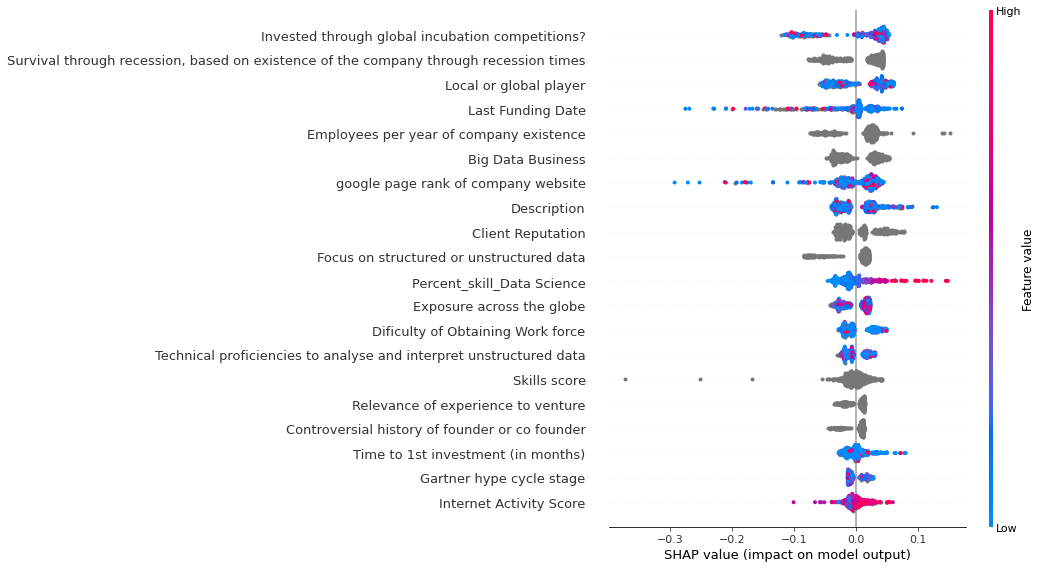

In [29]:
shap.summary_plot(shap_values, X_display)

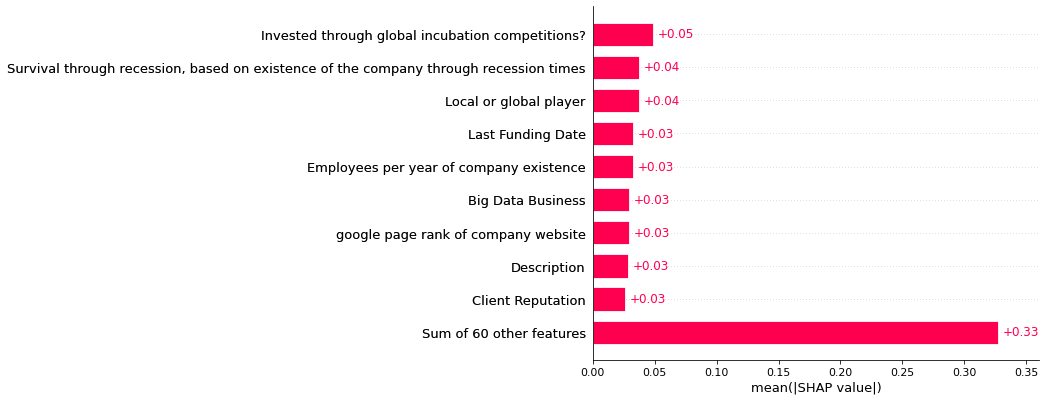

In [30]:
shap.plots.bar(shap_values)

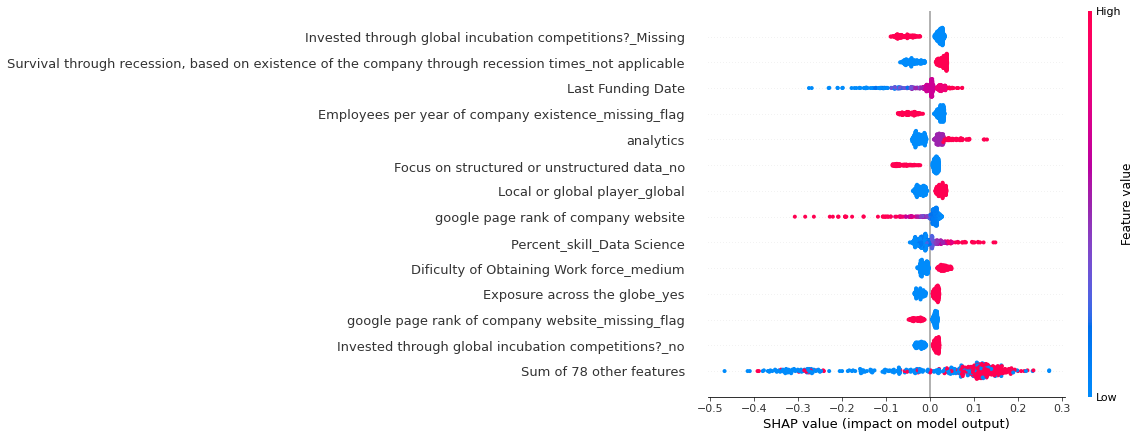

In [31]:
shap.plots.beeswarm(shap_values_raw, max_display=14)

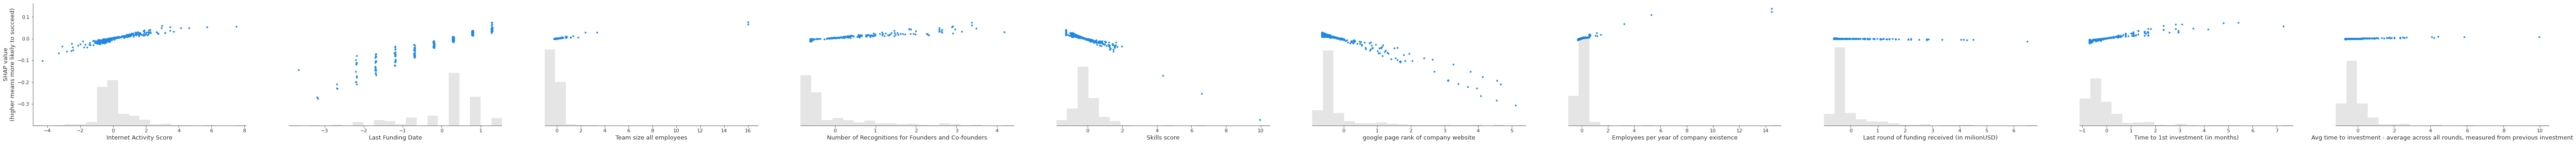

In [32]:
shap.plots.scatter(shap_values_raw[:,:10], ylabel="SHAP value\n(higher means more likely to succeed)", show=False)
plt.gcf().set_size_inches(100, 5)
plt.show()

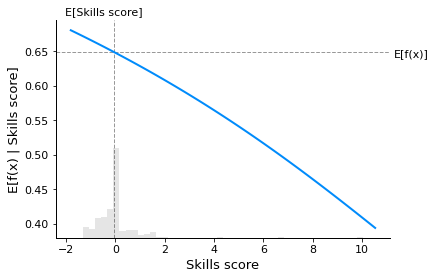

In [33]:
fig,ax = shap.partial_dependence_plot(
    "Skills score", model_proba, X_preview, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False)

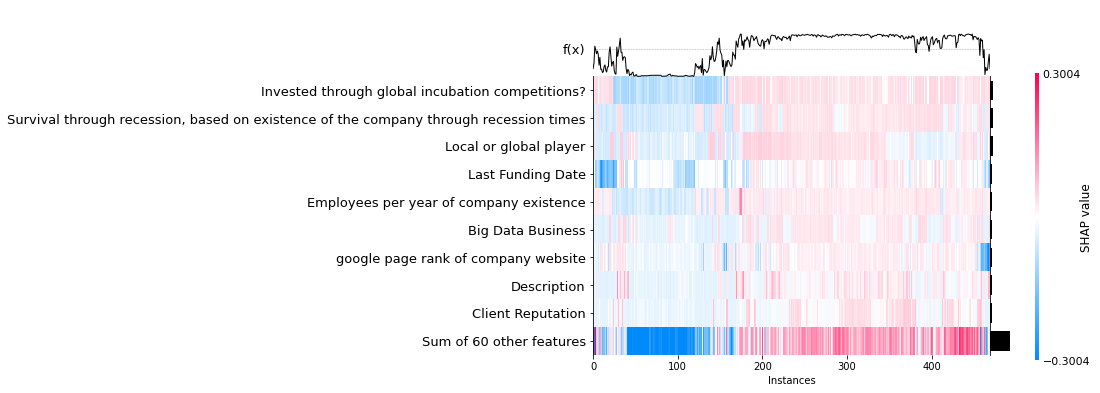

In [34]:
shap.plots.heatmap(shap_values)

In [35]:
shap.initjs()
shap.force_plot(shap_EV, shap_values.values, X_display)

In [36]:
shap.initjs()
shap.force_plot(shap_EV, shap_values.values[2,:], X_display.iloc[2,:])

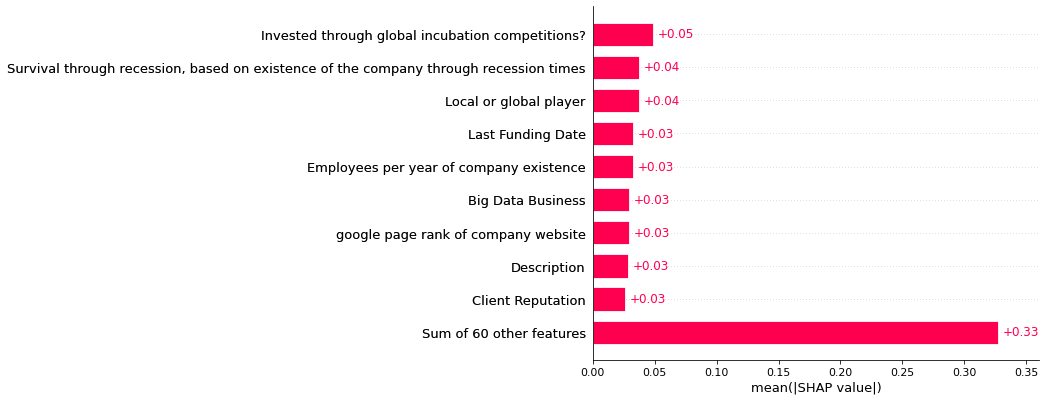

In [37]:
shap.plots.bar(shap_values)

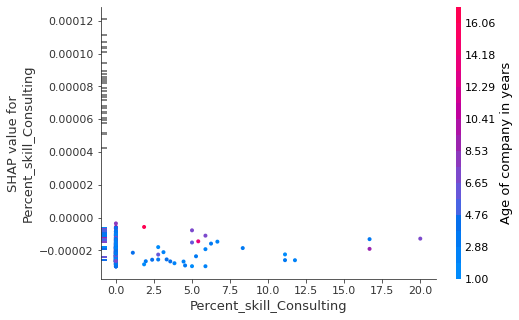

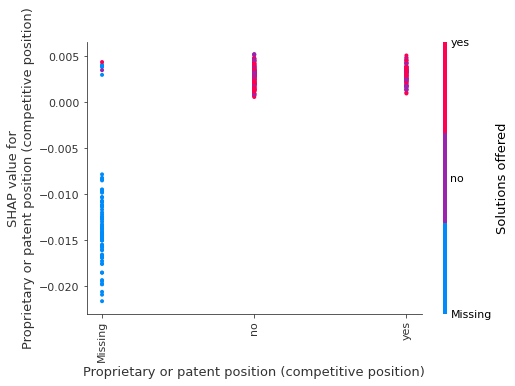

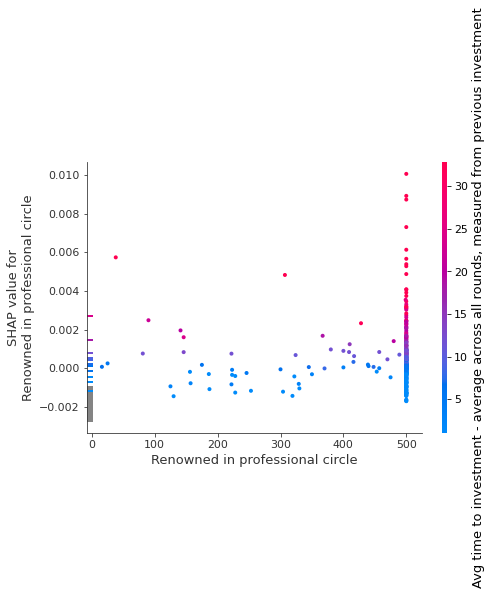

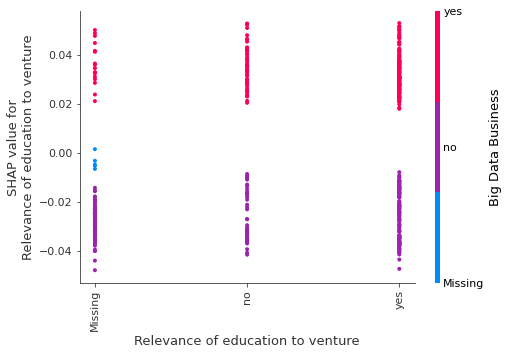

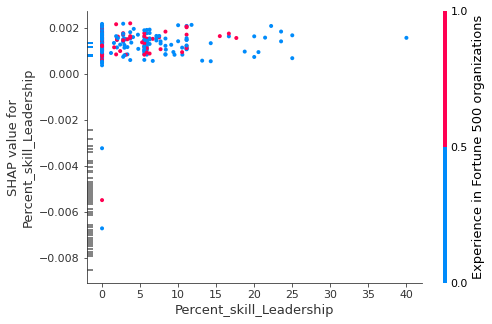

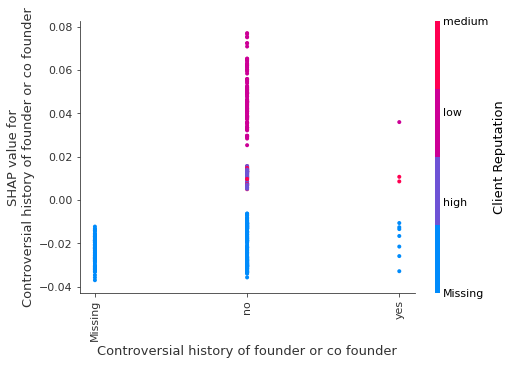

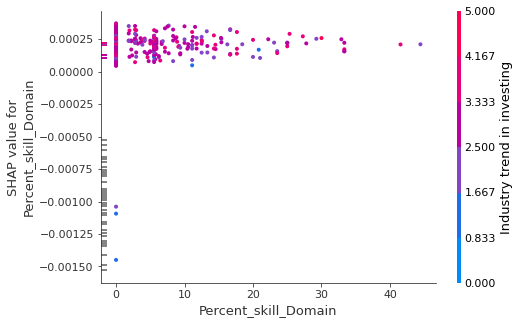

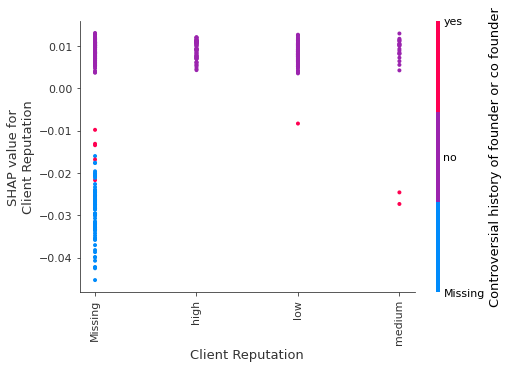

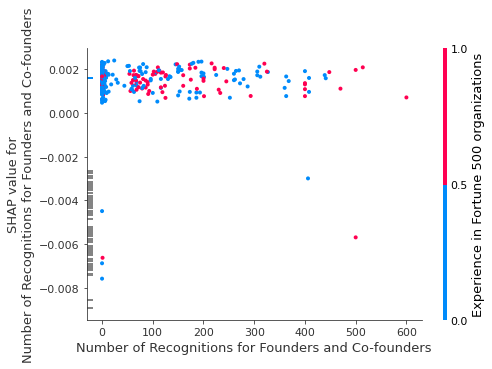

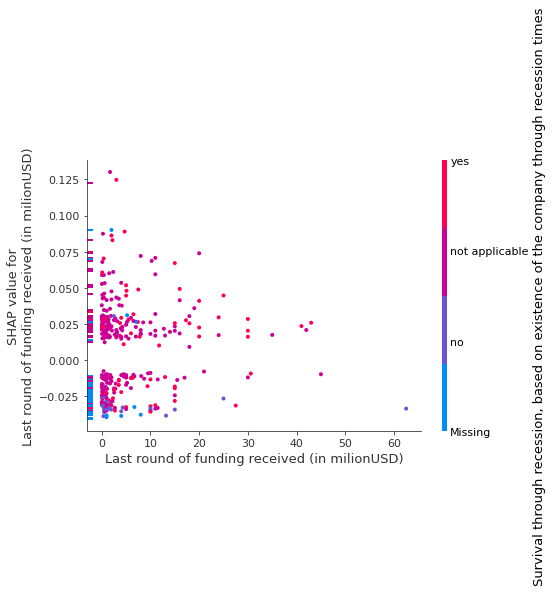

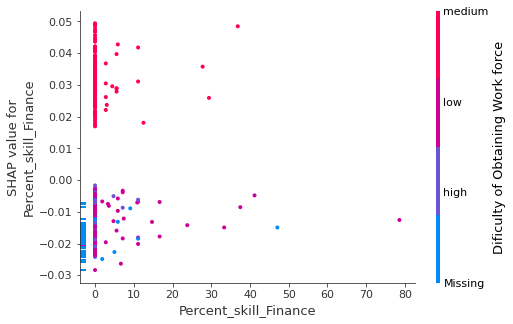

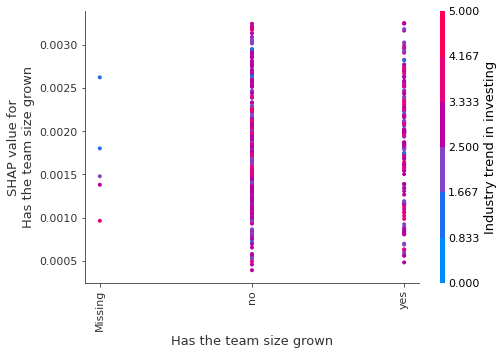

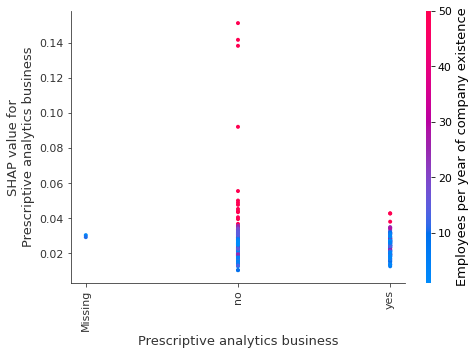

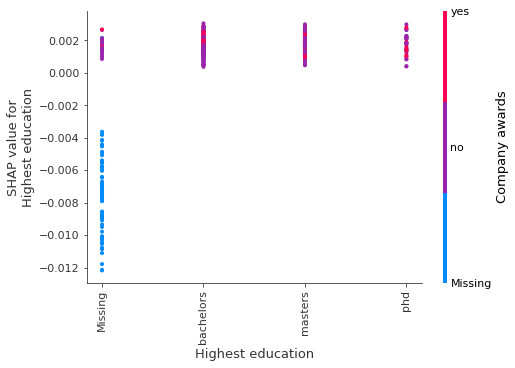

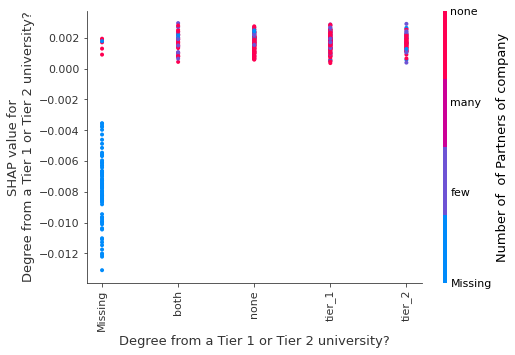

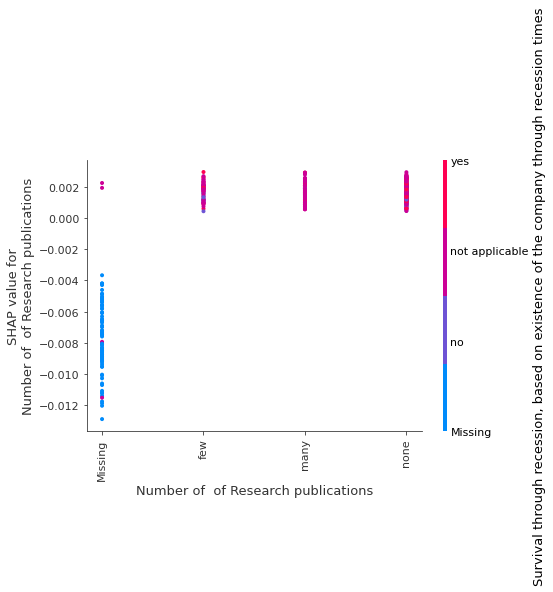

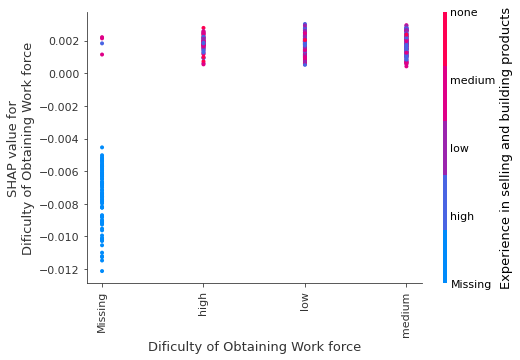

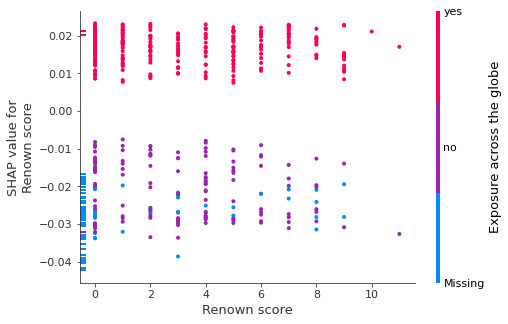

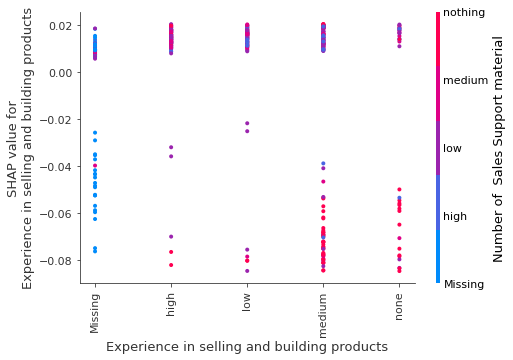

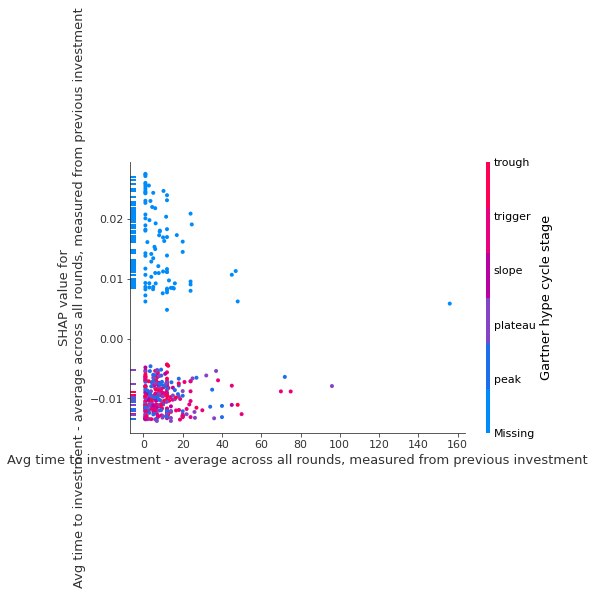

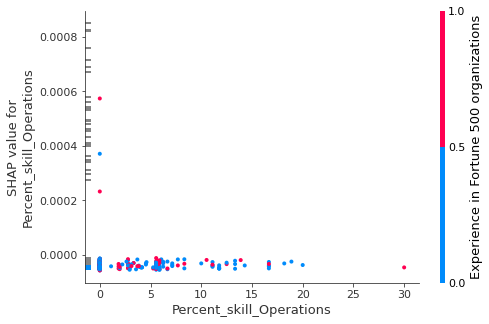

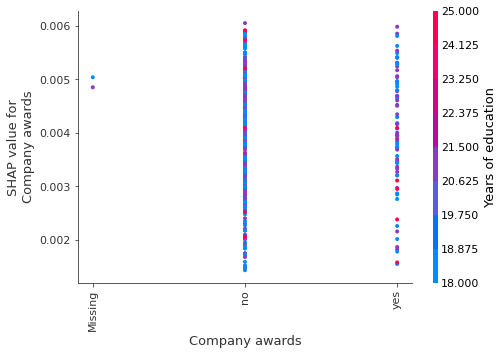

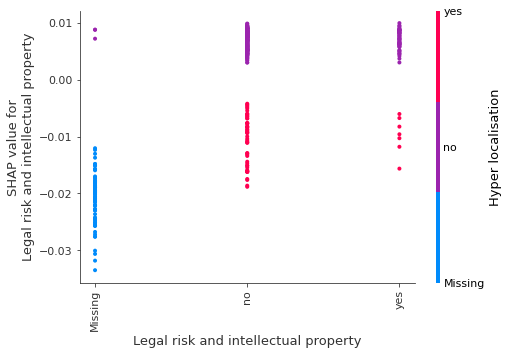

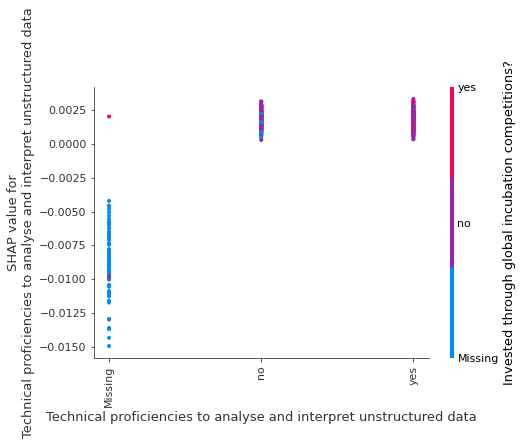

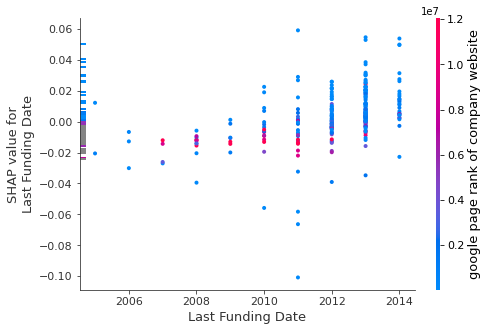

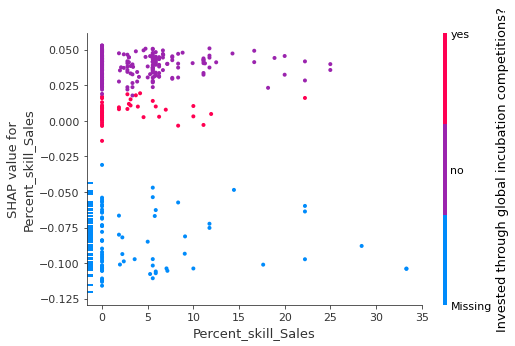

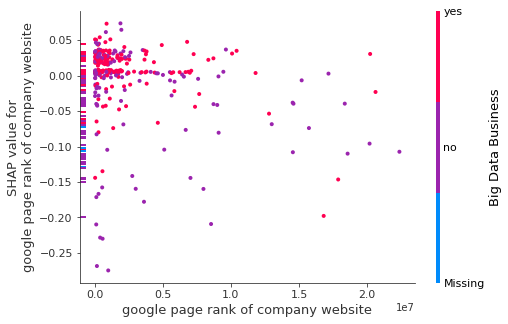

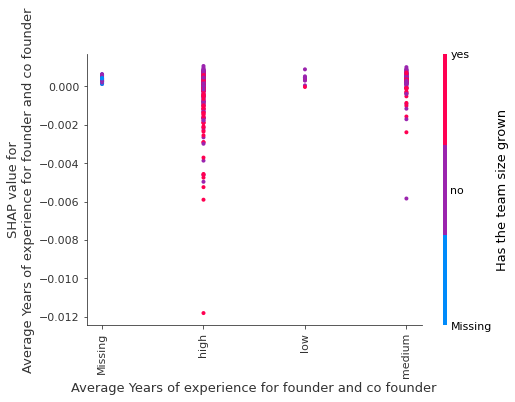

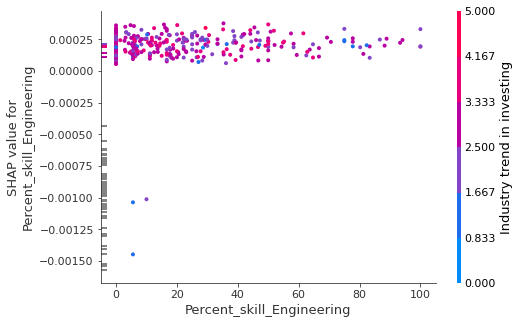

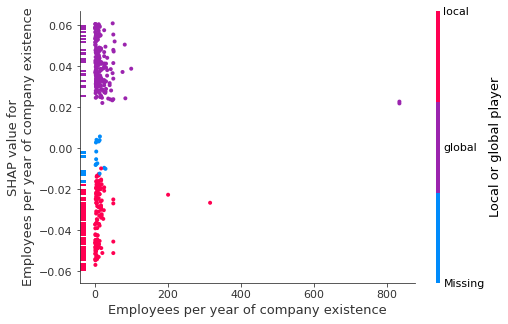

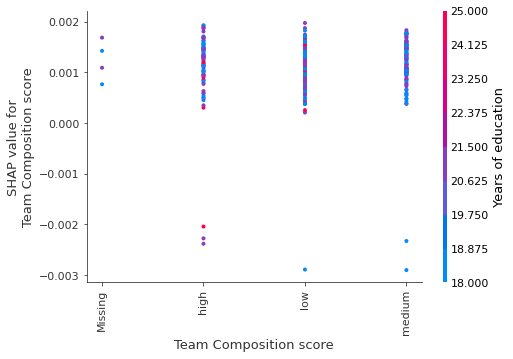

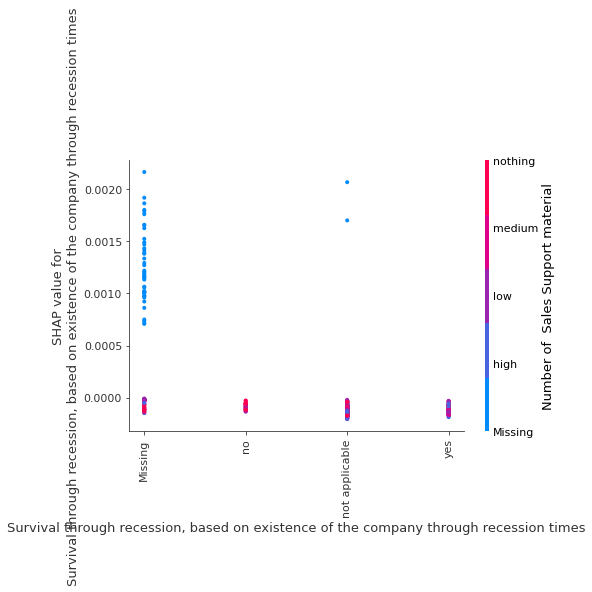

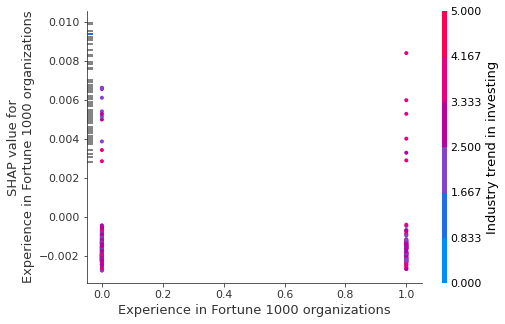

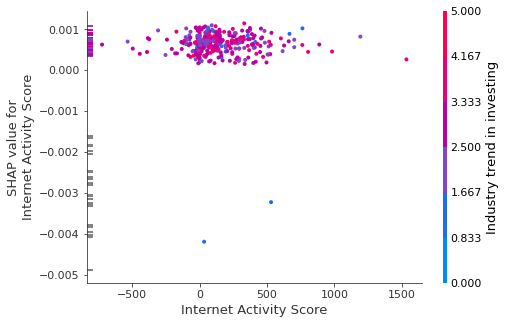

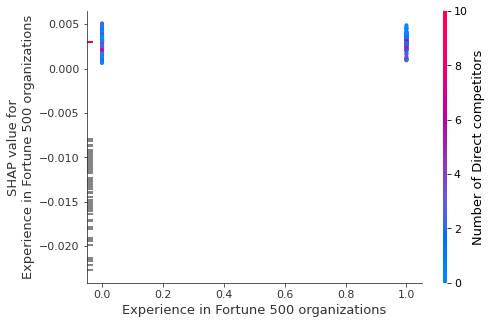

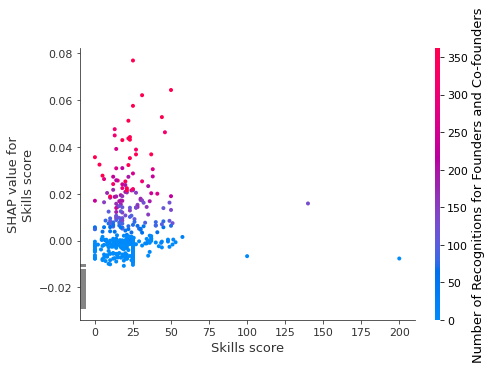

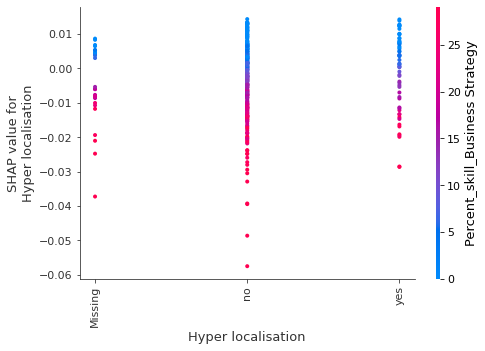

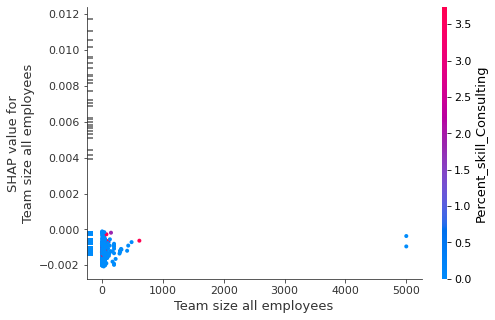

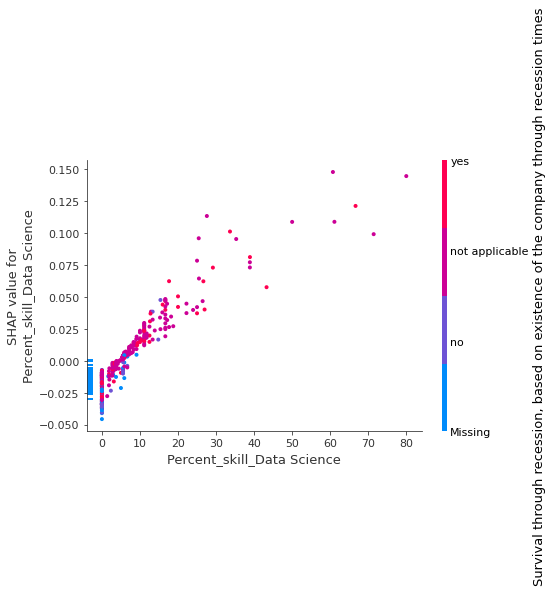

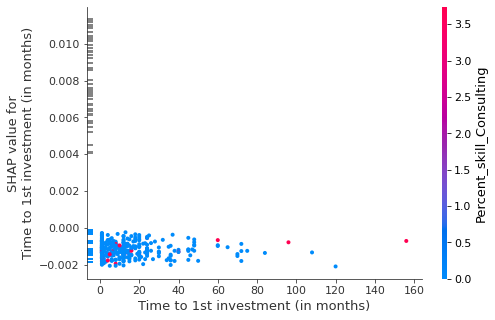

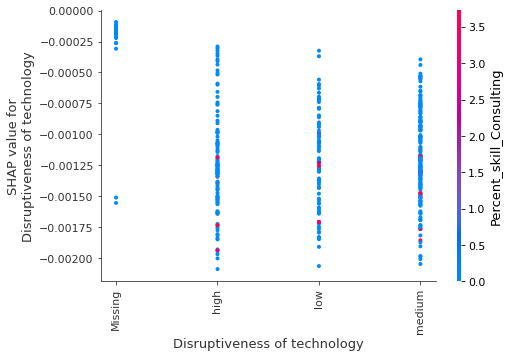

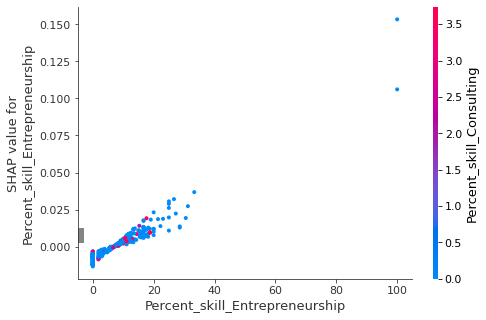

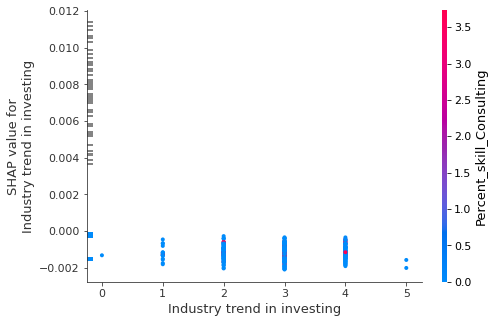

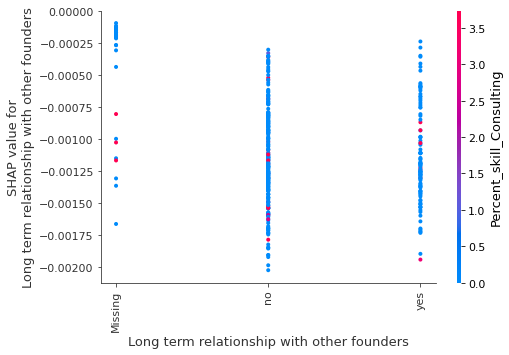

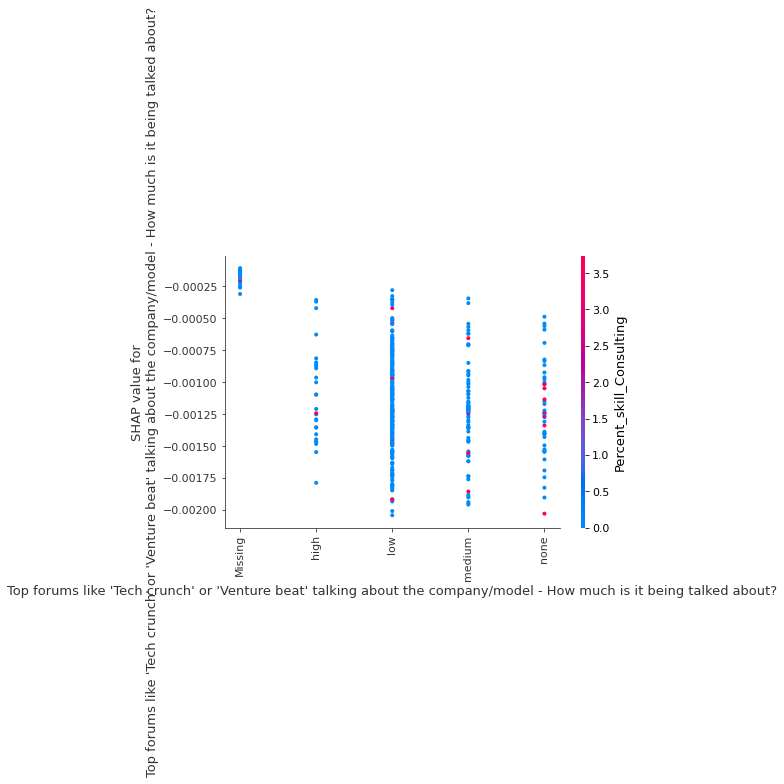

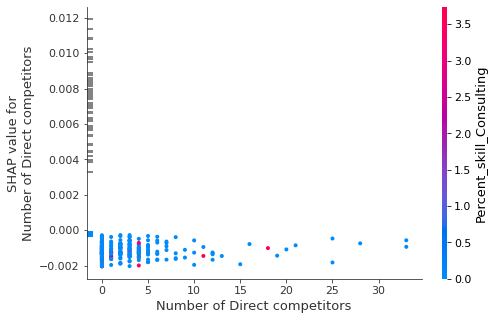

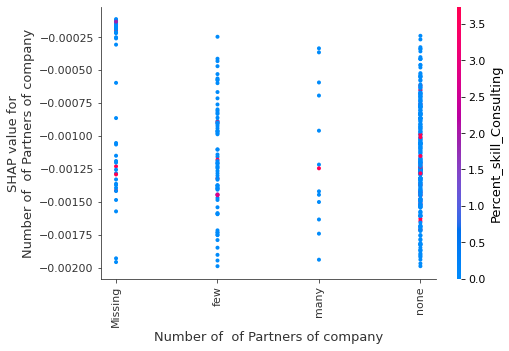

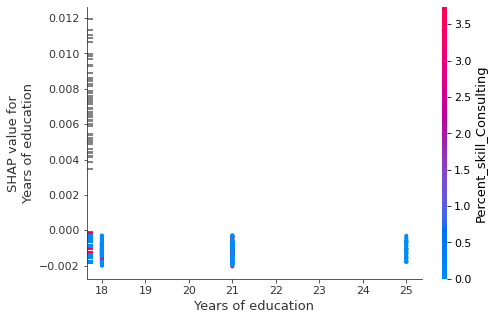

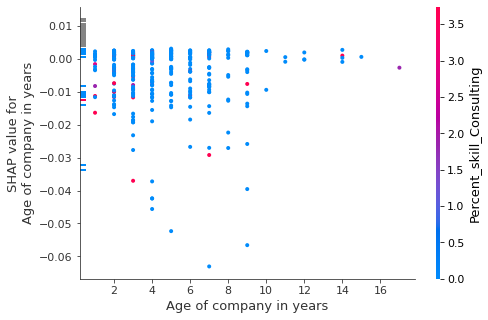

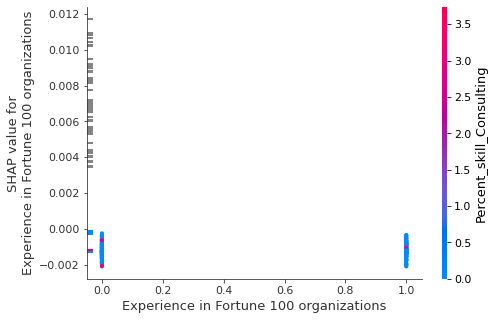

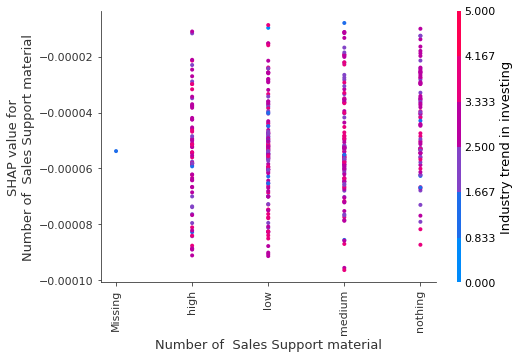

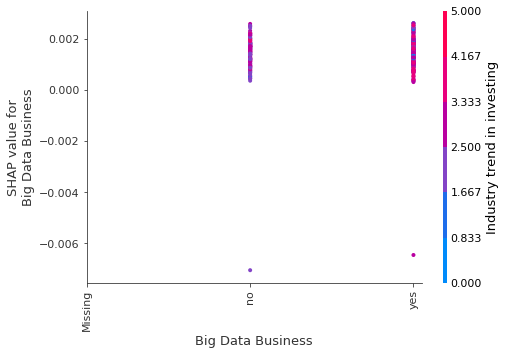

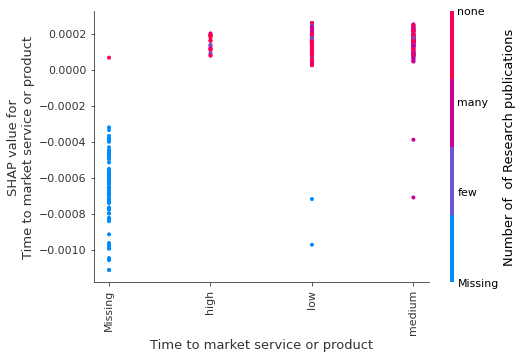

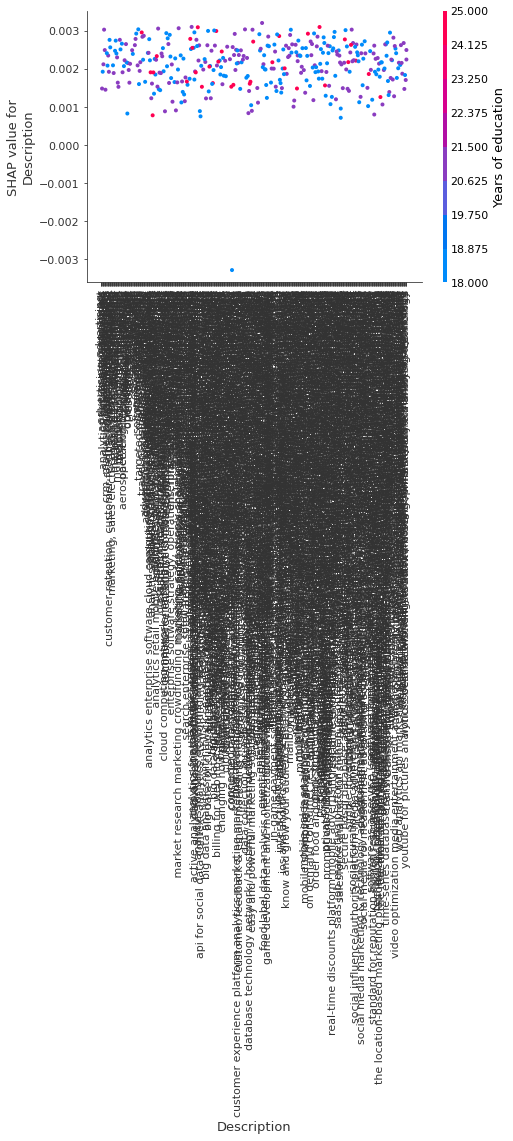

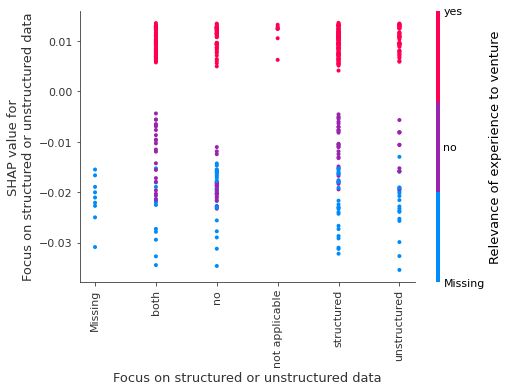

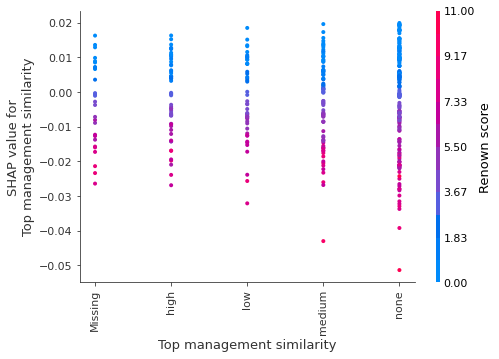

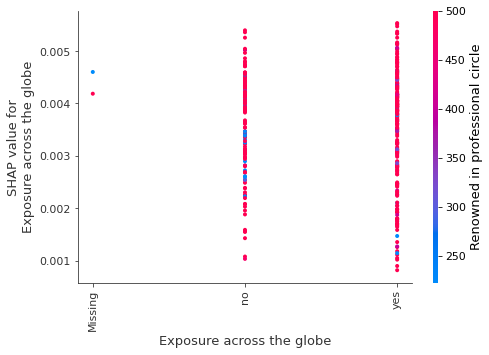

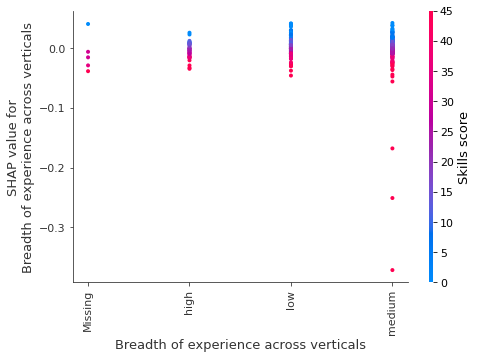

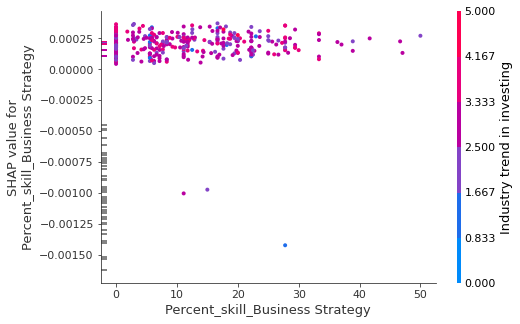

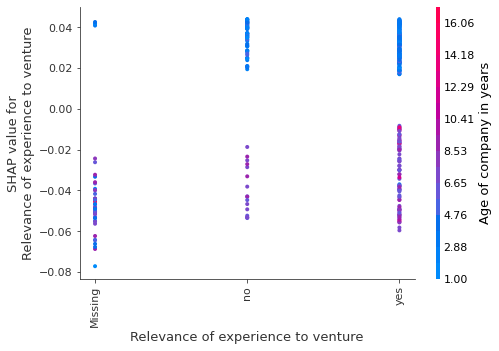

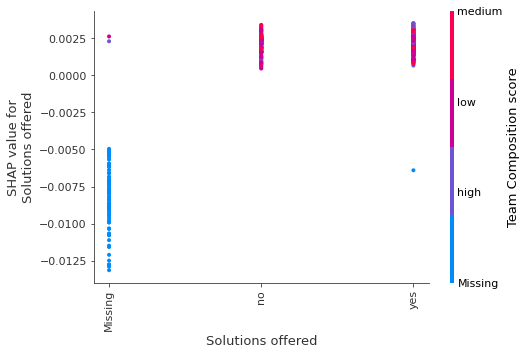

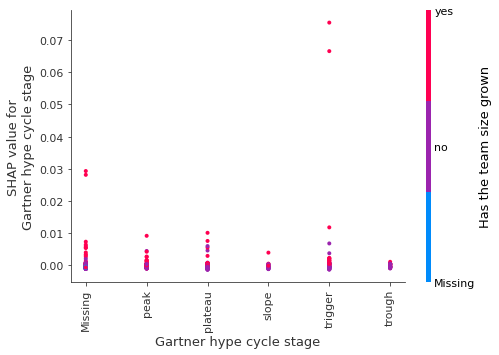

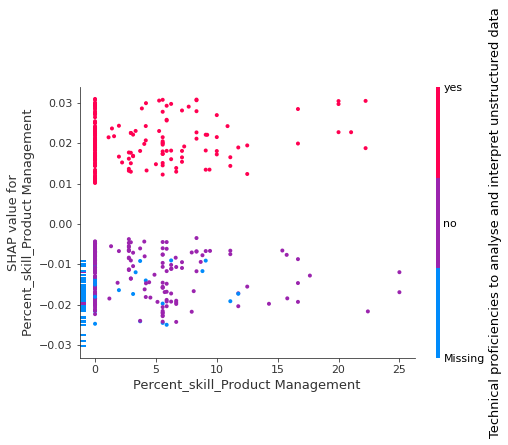

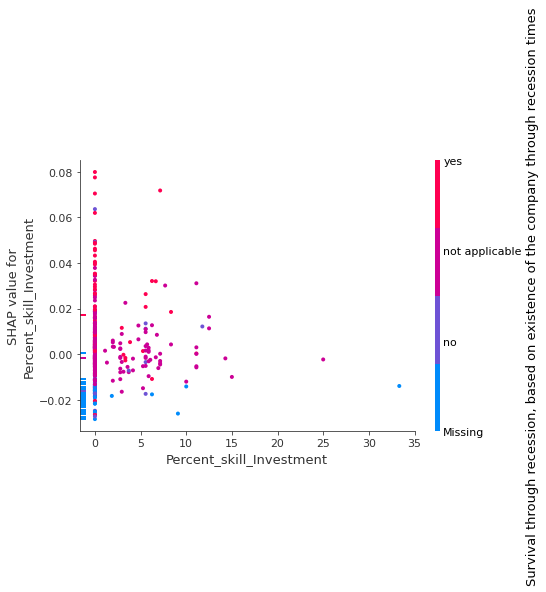

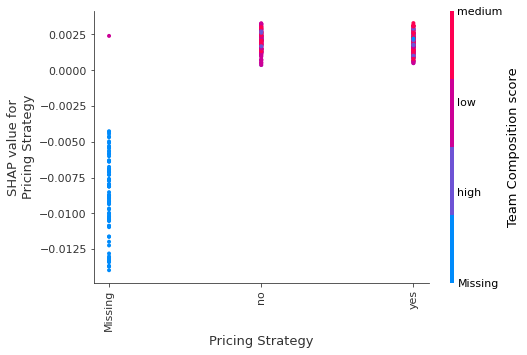

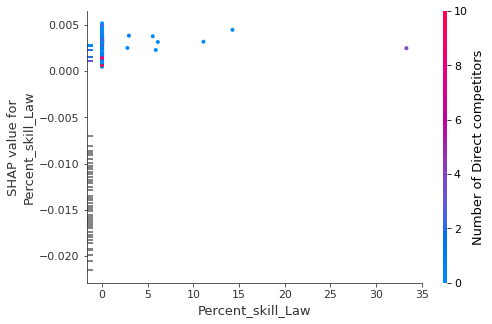

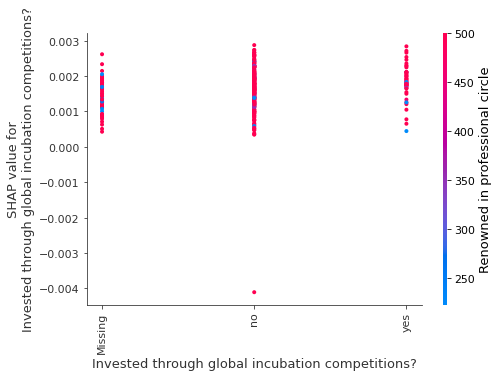

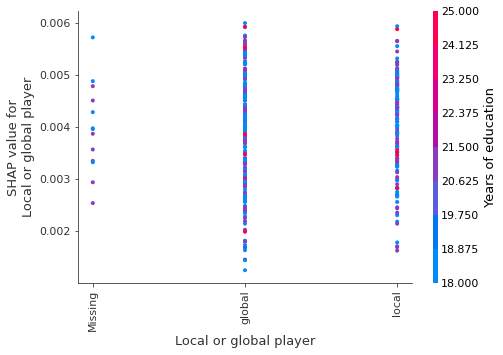

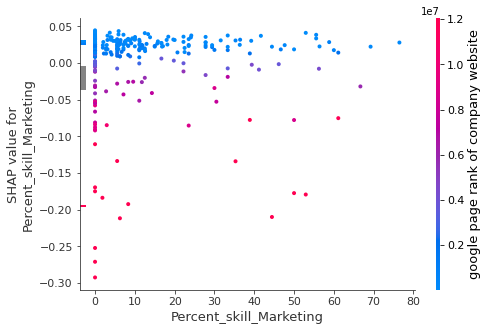

In [38]:
for col in X_display:
    shap.dependence_plot(col, shap_values.values, features=X_display)

## Data export

In [39]:
pred = pd.DataFrame(model.predict_proba(X)[:,1], X.index, columns=['Logit_predictions'])
pred.to_csv('predictions.csv')
shap_dataset.to_csv('shap_values.csv')